In [1]:
import pandas as pd
import numpy as np
import json
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

from utils import (
    save_as_json,
    # rgba_to_hex,
    # convert_rgba_to_hex,
    get_graph_from_matrix_customized_color,
    # get_graph_from_cluster_data,
    append_cluster_color,
    get_cluster_plot,
    get_correlation_df_per_cluster,
    get_graph_from_cluster_data_without_color,
    get_average_sentiment_and_size_per_cluster,
    append_mean_coefficients_per_cluster,
)

pd.set_option("display.max_colwidth", None)

matrix = pd.read_json(
    "../graph_network/plots_graphs_or_dfs_archive/matrix_iv_29-04-24.json"
)

In [7]:
senti = pd.read_json("../graph_network/full_data_iv_29-04-24.json")

In [77]:
G, N = get_graph_from_matrix_customized_color(matrix)

## Shortest-Path

In [81]:
G = G.to_undirected()
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [82]:
path_lengths = dict(nx.all_pairs_shortest_path_length(G))
distance_matrix = np.zeros((len(G), len(G)))

nodes = list(G.nodes())
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        if node_j in path_lengths[node_i]:
            distance_matrix[i, j] = path_lengths[node_i][node_j]

linked = linkage(squareform(distance_matrix), method='ward')

/var/folders/z3/m0_jmm793c13j56bgg5x44dw0000gn/T/ipykernel_26136/235668104.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, 'single')


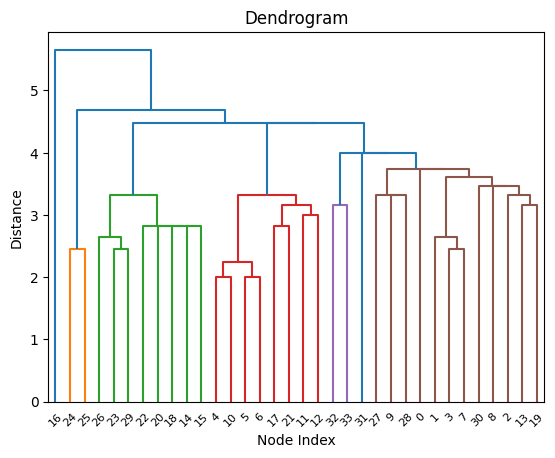

In [86]:
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Beispielgraph erstellen
G = nx.karate_club_graph()

# Kürzeste Pfade zwischen allen Knotenpaaren berechnen
path_lengths = dict(nx.all_pairs_shortest_path_length(G))

# Distanzmatrix erstellen
num_nodes = len(G.nodes())
dist_matrix = np.zeros((num_nodes, num_nodes))

for u, lengths in path_lengths.items():
    for v, dist in lengths.items():
        dist_matrix[u][v] = dist

# Hierarchisches Clustering anwenden
Z = linkage(dist_matrix, 'single')
dendrogram(Z)

# Dendrogram anzeigen
plt.title("Dendrogram")
plt.xlabel('Node Index')
plt.ylabel('Distance')
plt.show()


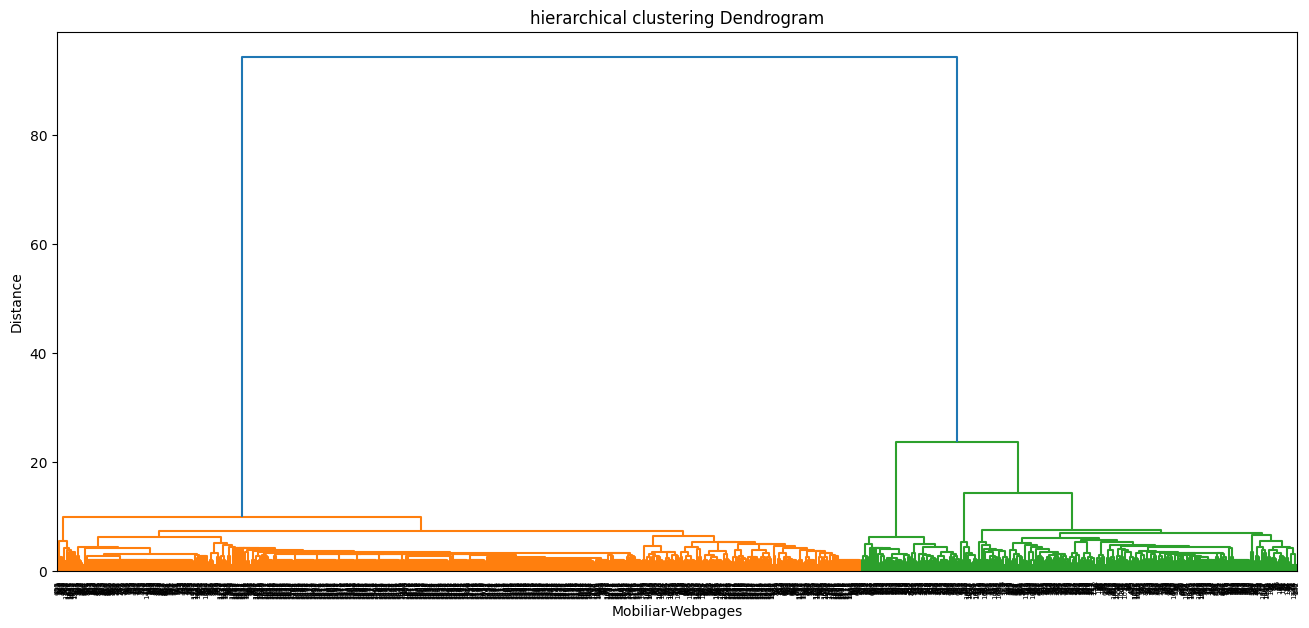

In [8]:
plt.figure(figsize=(16, 7))
dendrogram(linked, )#labels=list(G.nodes())
plt.title('hierarchical clustering Dendrogram')
plt.xlabel('Mobiliar-Webpages')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Bestimmen der Cluster bei einer bestimmten maximalen Distanz
max_distance = 6
cluster_labels = fcluster(linked, max_distance, criterion='distance')

# Erstellen eines Dictionaries, das jeden Knoten seinem Cluster zuweist
node_to_cluster = {node: int(cluster) for node, cluster in zip(nodes, cluster_labels)}

In [8]:
graph_clustering_shortest_path = senti.copy()
graph_clustering_shortest_path['cluster_id'] = graph_clustering_shortest_path['url'].map(node_to_cluster)

### Coloring

In [87]:
graph_clustering_shortest_path = pd.read_json("../graph_network/graph_clustering_shortest_path_03-05-24.json")

In [3]:
print("Rows count:", graph_clustering_shortest_path.shape[0])
graph_clustering_shortest_path = graph_clustering_shortest_path.dropna(subset=["cluster_id"])
print("Rows count:", graph_clustering_shortest_path.shape[0])

Rows count: 1718
Rows count: 1718


In [11]:
graph_clustering_shortest_path["cluster_id"].value_counts()

cluster_id
5.0     620
10.0    317
3.0     243
4.0     184
12.0     72
6.0      69
7.0      67
9.0      50
2.0      44
8.0      24
1.0      22
11.0      6
Name: count, dtype: int64

In [90]:
get_average_sentiment_and_size_per_cluster(graph_clustering_shortest_path, "cluster_id").sort_values("cluster_size", ascending=False)

,cluster_id,avg_neg,avg_neu,avg_pos,cluster_size
4,5,0.296175,0.145904,0.557921,620
9,10,0.395900,0.158113,0.445987,317
2,3,0.279379,0.155789,0.564832,243
3,4,0.387489,0.114738,0.497773,184
11,12,0.419981,0.180308,0.399711,72
5,6,0.386005,0.152469,0.461525,69
6,7,0.383331,0.162421,0.454247,67
8,9,0.367054,0.182843,0.450102,50
1,2,0.267896,0.134429,0.597675,44
7,8,0.384700,0.190446,0.424854,24


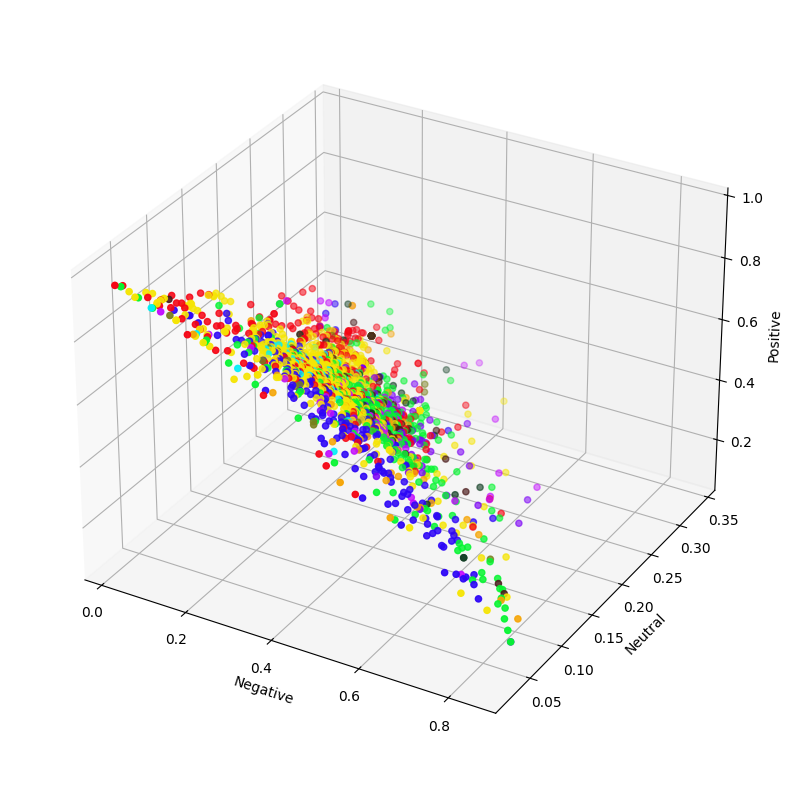

In [91]:
# specific_colors = {
#     # 1: "red", 2: "green", 3: "blue", 4: "yellow", 5: "orange", 6: "purple", 7:"winered"
#     5: "#f5e505", 10: "#05f531", 3: "#f50515", 4: "#2d05f7", 12: "#7c02f5", 6: "#f5a505", 7:"#c20aff", 9:"#4a1a1a", 2:"#02eff7", 8:"#144026", 1:"#79801d"
    
# }
# append_cluster_color(graph_clustering_shortest_path, "cluster_id", specific_colors)
get_cluster_plot(graph_clustering_shortest_path, "cluster_id")

In [14]:
# save_as_json(graph_clustering_shortest_path, "graph_clustering_shortest_path")

### Create Graph

In [94]:
# G, N = get_graph_from_cluster_data(matrix, graph_clustering_shortest_path, "cluster_id")
# graph_clustering_shortest_path = pd.read_json("../graph_network/graph_clustering_shortest_path_04-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, graph_clustering_shortest_path, "cluster_id") 
N.show("graph_clustering_shortest_path.html")

### Stats

In [6]:
graph_clustering_shortest_path["cluster_id"].nunique()

12

In [6]:
correlation_of_mean_sentiment_per_cluster, correlation_matrix_per_cluster = get_correlation_df_per_cluster(graph_clustering_shortest_path, "cluster_id")
correlation_of_mean_sentiment_per_cluster

Number of Clusters that we can calculate the correlation: 12 
 containing: 1718 Pages/Nodes.


,avgc_negative,avgc_neutral,avgc_positive
avgc_negative,1.000000,0.169142,-0.905020
avgc_neutral,0.169142,1.000000,-0.572318
avgc_positive,-0.905020,-0.572318,1.000000


In [7]:
get_average_sentiment_and_size_per_cluster(graph_clustering_shortest_path, "cluster_id")

negative   neutral  positive
cluster_id                                       
1.0        negative  1.000000  0.237430 -0.932031
           neutral   0.237430  1.000000 -0.573308
           positive -0.932031 -0.573308  1.000000
2.0        negative  1.000000  0.478657 -0.938822
           neutral   0.478657  1.000000 -0.751760
           positive -0.938822 -0.751760  1.000000
3.0        negative  1.000000  0.313914 -0.935650
           neutral   0.313914  1.000000 -0.628803
           positive -0.935650 -0.628803  1.000000
4.0        negative  1.000000 -0.178104 -0.982197
           neutral  -0.178104  1.000000 -0.009914
           positive -0.982197 -0.009914  1.000000
5.0        negative  1.000000  0.315738 -0.953984
           neutral   0.315738  1.000000 -0.585727
           positive -0.953984 -0.585727  1.000000
6.0        negative  1.000000 -0.435684 -0.934977
           neutral  -0.435684  1.000000  0.088082
           positive -0.934977  0.088082  1.000000
7.0        negative  1.000000  0.038135 -0.917398
           neutral   0.038135  1.000000 -0.432667
           positive -0.917398 -0.432667  1.000000
8.0        negative  1.000000 -0.661925 -0.951455
           neutral  -0.661925  1.000000  0.399084
           positive -0.951455  0.399084  1.000000
9.0        negative  1.000000 -0.442587 -0.940878
           neutral  -0.442587  1.000000  0.112658
           positive -0.940878  0.112658  1.000000
10.0       negative  1.000000 -0.182628 -0.949371
           neutral  -0.182628  1.000000 -0.135492
           positive -0.949371 -0.135492  1.000000
11.0       negative  1.000000 -0.940369 -0.962970
           neutral  -0.940369  1.000000  0.813838
           positive -0.962970  0.813838  1.000000
12.0       negative  1.000000 -0.444457 -0.944268
           neutral  -0.444457  1.000000  0.124809
           positive -0.944268  0.124809  1.000000

## Edge betweenness centrality - Girvan Newman Algorithm

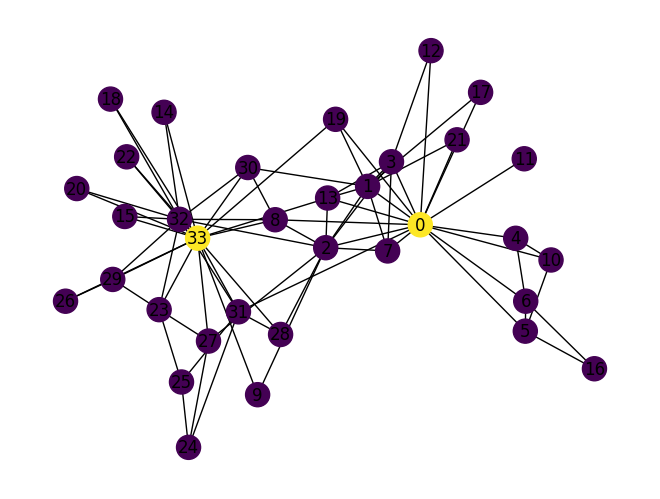

In [10]:
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np

# Erstellen Sie Ihren Graphen
G = nx.karate_club_graph()

# Berechnen Sie die Betweenness Centrality für jeden Knoten
centrality = nx.betweenness_centrality(G)
centrality_values = np.array(list(centrality.values())).reshape(-1, 1)

# Anwendung eines Clustering-Algorithmus, hier k-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(centrality_values)
labels = kmeans.labels_

# Knotenlabels zuordnen und den Graphen visualisieren
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=labels, with_labels=True, cmap='viridis')


In [73]:
G = G.to_undirected()
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [74]:
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G)
    return max(centrality, key=centrality.get)

# G = nx.karate_club_graph()

k = 20
comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    tuple(sorted(c) for c in communities)

print(communities)

({'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/bau-und-gebaeude', 'https://www.mobiliar.ch/news/schnee-zerstoert-kirschbaeume-ein-jahr-danach', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/vorsorge-und-gesundheit/unsere-vorsorgeprodukte/vorausschauende-sparversicherung/beratungsanfrage-vorausschauende-sparversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/datenschutz-und-sicherheit/datenschutzerklaerung-fuer-die-schadenfallbearbeitung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/kundenzufriedenheit', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/unfall-und-krankheit/leistungsuebersicht-ueber-die-obligatorische-unfallversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/fahrzeuge-und-transport/transportversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/berufliche-vorsorge/newsletter-berufliche-vorsorge/fi

In [75]:
community_id = {node: idx for idx, community in enumerate(communities) for node in community}

In [ ]:
# DENDOGRAM maybe here:
# https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm

#113 min timeout

In [76]:
graph_clustering_e_b_c = senti.copy()
graph_clustering_e_b_c['commun_id'] = graph_clustering_shortest_path['url'].map(community_id)

### Coloring

In [3]:
graph_clustering_e_b_c = pd.read_json("../graph_network/graph_clustering_edge_betweenness_centrality_03-05-24.json")

In [6]:
print("Rows count:", graph_clustering_e_b_c.shape[0])
graph_clustering_e_b_c = graph_clustering_e_b_c.dropna(subset=["commun_id"])
print("Rows count:", graph_clustering_e_b_c.shape[0])

Rows count: 1718
Rows count: 1718


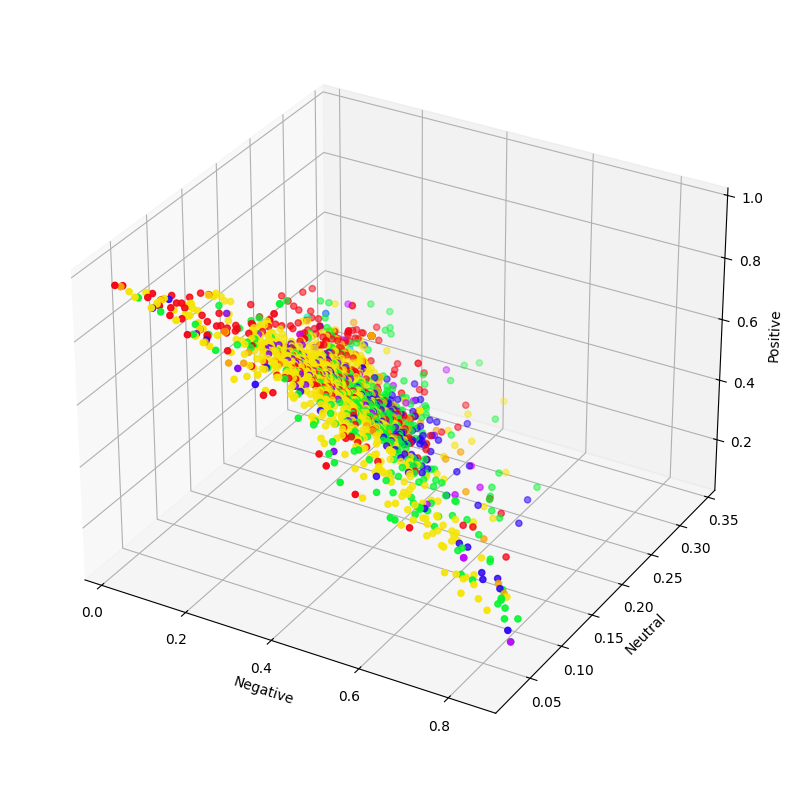

In [7]:
# specific_colors = {
#     5: "#f5e505", 0: "#05f531", 7: "#f50515", 2: "#2d05f7", 8: "#7c02f5", 1: "#f5a505", 4:"#c20aff"
# }
# append_cluster_color(graph_clustering_e_b_c, "commun_id",specific_colors)
get_cluster_plot(graph_clustering_e_b_c, "commun_id")

### Create Graph

In [3]:
# save_as_json(graph_clustering_e_b_c, "graph_clustering_edge_betweenness_centrality")
graph_clustering_e_b_c = pd.read_json("../graph_network/graph_clustering_edge_betweenness_centrality_03-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, graph_clustering_e_b_c, "commun_id") 
N.show("graph_clustering_edge_betweenness_centrality.html")

### Stats

In [80]:
graph_clustering_e_b_c["commun_id"].nunique()
correlation_of_mean_sentiment_per_cluster, correlation_matrix_per_cluster = get_correlation_df_per_cluster(graph_clustering_e_b_c, "commun_id")
correlation_of_mean_sentiment_per_cluster

Number of Clusters that we can calculate the correlation: 15 
 containing: 1713 Pages/Nodes.


,avgc_negative,avgc_neutral,avgc_positive
avgc_negative,1.000000,-0.136827,-0.848521
avgc_neutral,-0.136827,1.000000,-0.408084
avgc_positive,-0.848521,-0.408084,1.000000


In [15]:
get_average_sentiment_and_size_per_cluster(graph_clustering_e_b_c, "commun_id")

NameError: name 'get_average_sentiment_and_size_per_cluster' is not defined

In [9]:
graph_clustering_e_b_c['commun_id'].value_counts()

commun_id
5     788
0     365
7     248
2     129
1      83
8      53
4      27
9       4
3       4
13      2
6       2
14      2
11      2
12      2
10      2
15      1
16      1
17      1
18      1
19      1
Name: count, dtype: int64

# URL Clustering

### Helper Functions

In [62]:
def get_url_path(url):
    from urllib.parse import urlparse
    parsed_url = urlparse(url)
    return parsed_url.path, parsed_url.netloc

def get_url_list(url):
    path, domain = get_url_path(url.strip("/"))
    url_elements = [domain] 
    if path:
        url_elements.extend(x.strip() for x in path.split("/") if x.strip())  
    return url_elements

def append_url_list_to_df(df, url_col="url"):
    df["url_elements_list"] = df[url_col].apply(get_url_list)
    return df 
    
def get_list_length(df, url_list_col):
    df['list_length'] = df[url_list_col].apply(len)
    return df

senti = append_url_list_to_df(senti)

In [60]:
def group_by_list_element(df, column_name, position):
    df_copy = df.copy()
    element_groups = {}
    df_copy["group_id"] = df.index
    unique_group_id = 1  # Startwert für Gruppen-IDs

    for idx, row in df_copy.iterrows():
        # Prüfen, ob die Liste lang genug ist
        if position < len(row[column_name]):
            # Erstellen eines Tupels der Elemente bis zur angegebenen Position
            current_elements = tuple(row[column_name][:position + 1])
            if current_elements in element_groups:
                new_group_id = element_groups[current_elements]
            else:
                new_group_id = unique_group_id
                element_groups[current_elements] = new_group_id
                unique_group_id += 1  # Erhöhe den Zähler für Gruppen-IDs
        else:
            # Falls die Liste kürzer ist, als die geforderte Position,
            # weisen wir eine neue, eindeutige Gruppen-ID zu
            new_group_id = unique_group_id
            unique_group_id += 1  # Erhöhe den Zähler für Gruppen-IDs

        df_copy.at[idx, "group_id"] = new_group_id

    return df_copy

### Clustering

In [79]:
url_clustering_1 = group_by_list_element(senti, "url_elements_list", 1)
url_clustering_2 = group_by_list_element(senti, "url_elements_list", 2)
url_clustering_3 = group_by_list_element(senti, "url_elements_list", 3)

# url_clustering_3["group_id"].nunique()

In [71]:
url_clustering_ = group_by_list_element(senti, "url_elements_list", 1)
url_clustering_["group_id"].nunique()

1746

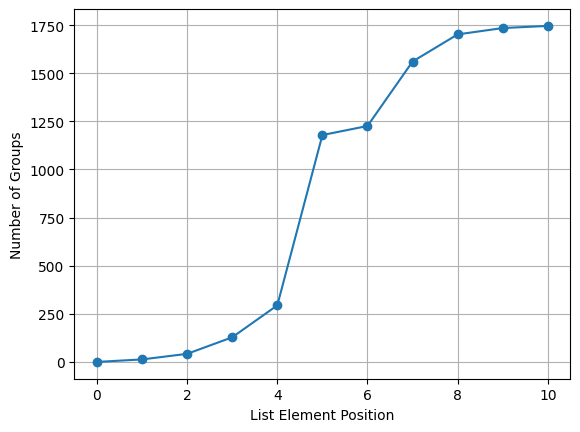

In [72]:
fig, ax = plt.subplots()
x = [0,1,2,3,4,5,6,7,8,9,10]
y = [0,13,42,128,294,1179,1226,1561,1702,1735,1746]
# ax.plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o')
# plt.plot(y)
ax.set(xlabel='List Element Position', ylabel='Number of Groups',
       title='')
ax.grid()
plt.show()

### Coloring

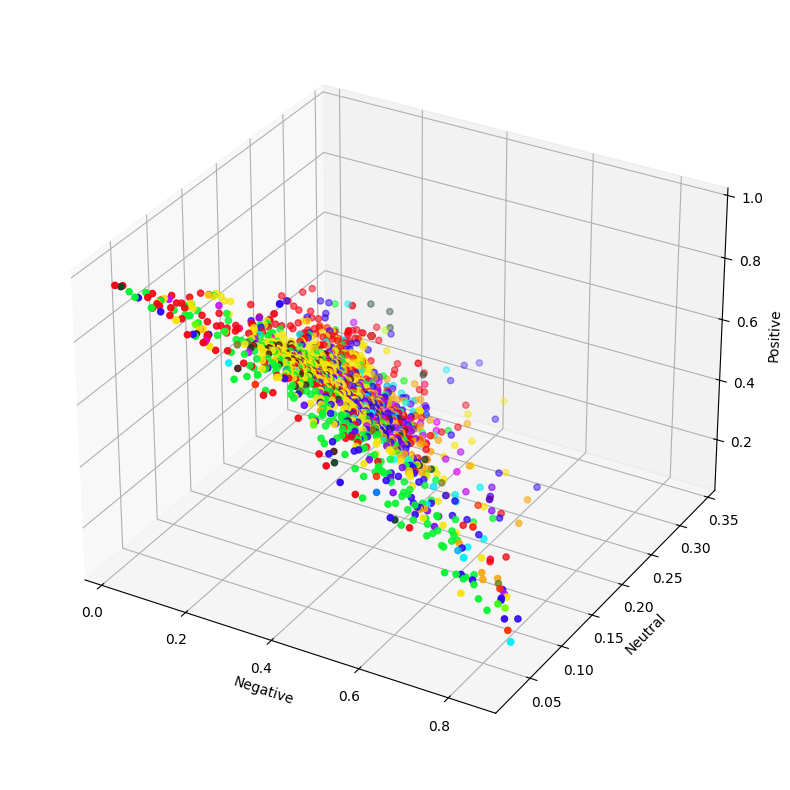

In [74]:
# specific_colors = {
#    13: "#f5e505", 11: "#05f531", 14: "#f50515", 8: "#2d05f7", 2: "#f5a505", 16: "#7c02f5", 4:"#c20aff", 12:"#4a1a1a", 7:"#02eff7", 10:"#144026", 32:"#79801d"
# }
# append_cluster_color(url_clustering_2, "group_id", specific_colors)
url_clustering_2 = pd.read_json("../graph_network/url_clustering_2_04-05-24.json")
get_cluster_plot(url_clustering_2, "group_id")

# save_as_json(url_clustering_2, "url_clustering_2")

In [6]:
url_clustering_2["group_id"].value_counts()[:20]

group_id
13     527
11     257
14     253
8      195
2       97
16      64
4       52
12      49
7       32
10      26
32      18
18      13
109     11
6       10
9        8
96       5
73       5
15       4
106      4
30       2
Name: count, dtype: int64

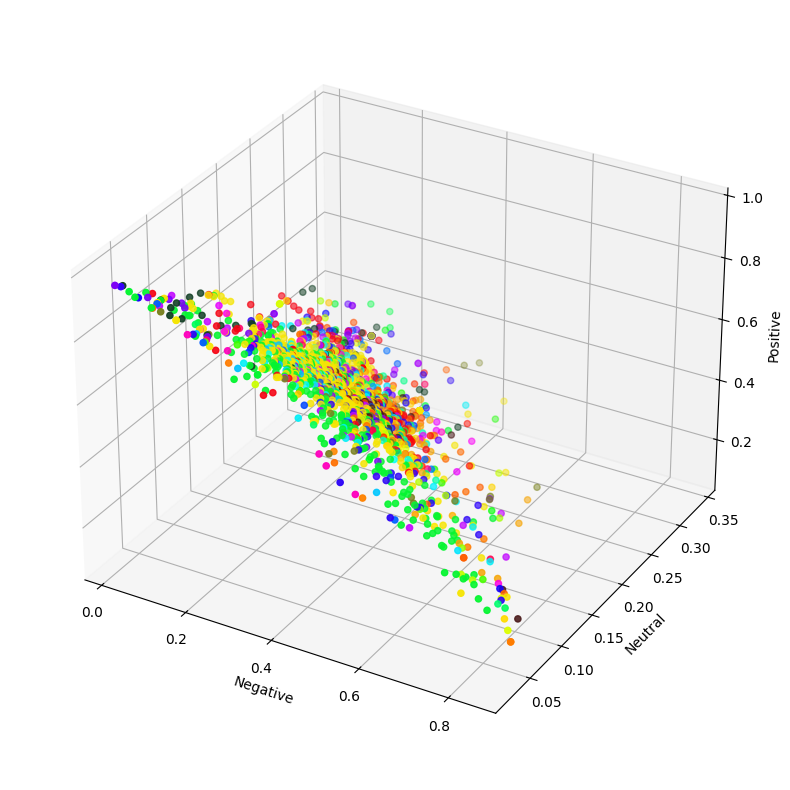

In [35]:
# specific_colors = {
#    176: "#f5e505", 166: "#05f531", 108: "#f50515", 90: "#2d05f7", 12: "#f5a505", 271: "#7c02f5", 283:"#c20aff", 20:"#4a1a1a", 99:"#02eff7", 162:"#144026", 69:"#79801d"
# }
# append_cluster_color(url_clustering_3, "group_id", specific_colors)
url_clustering_3 = pd.read_json("../graph_network/url_clustering_3_04-05-24.json")
get_cluster_plot(url_clustering_3, "group_id")
# save_as_json(url_clustering_3, "url_clustering_3")

In [ ]:
url_clustering_2[url_clustering_2["group_id"]==12][["url_elements_list"]][:20]

In [91]:
url_clustering_3[url_clustering_3["group_id"]==90][["url_elements_list"]][:20]

,url_elements_list
193,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, loesungen-fuer-unternehmen]"
234,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, balanceakt-zwischen-arbeit-und-privatleben]"
235,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, eingliedern-statt-ausschliessen]"
268,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge]"
287,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, was-braucht-es-fuer-eine-erfolgreiche-weidereingliederung]"
290,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge]"
297,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, modulare-loesungen-fuer-pensionskassen]"
299,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, wie-steht-es-um-das-vertrauen-in-die-altersvorsorge]"
301,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, newsletter-berufliche-vorsorge]"
303,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, im-case-management-von-betroffenen-lernen]"


10 und 11 dürfen bei pos 3 nicht in der selben gruppe sein

In [83]:
url_clustering_3.iloc[[10]][["pagetitle","url_elements_list","group_id"]]
url_clustering_3.iloc[[25]][["pagetitle","url_elements_list","group_id"]]

,pagetitle,url_elements_list,group_id
25,Vor dem Umzug auch an die Versicherung gedacht?,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, ratgeber, vor-dem-umzug-auch-an-die-versicherung-gedacht]",12


### Create Graph

In [93]:
# graph_url_clustering_3 = pd.read_json("../graph_network/url_clustering_3_04-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, url_clustering_3, "group_id") 
N.show("graph_url_clustering_3.html")

In [95]:
# graph_url_clustering_2 = pd.read_json("../graph_network/url_clustering_2_04-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, url_clustering_2, "group_id") 
N.show("graph_url_clustering_2.html")

### Cluster Analysis

In [4]:
append_mean_coefficients_per_cluster(url_clustering_2, "group_id")[
    [
        "negative",
        "neutral",
        "positive",
        "avg_group_neg",
        "avg_group_neu",
        "avg_group_pos",
    ]
].corr()[["negative", "neutral", "positive"]][3:6]

,negative,neutral,positive
avg_group_neg,0.398450,0.103141,-0.400395
avg_group_neu,0.108552,0.378588,-0.215915
avg_group_pos,-0.383960,-0.196731,0.415505


In [5]:
append_mean_coefficients_per_cluster(url_clustering_3, "group_id")[
    [
        "negative",
        "neutral",
        "positive",
        "avg_group_neg",
        "avg_group_neu",
        "avg_group_pos",
    ]
].corr()[["negative", "neutral", "positive"]][3:6]

,negative,neutral,positive
avg_group_neg,0.476130,0.063591,-0.459145
avg_group_neu,0.066072,0.458250,-0.201417
avg_group_pos,-0.455692,-0.192395,0.479738


In [9]:
append_mean_coefficients_per_cluster(graph_clustering_shortest_path, "cluster_id")[
    [
        "negative",
        "neutral",
        "positive",
        "avg_cluster_neg",
        "avg_cluster_neu",
        "avg_cluster_pos",
    ]
].corr()[["negative", "neutral", "positive"]][3:6]

,negative,neutral,positive
avg_cluster_neg,0.405861,0.054785,-0.396024
avg_cluster_neu,0.058344,0.381099,-0.176701
avg_cluster_pos,-0.388140,-0.162618,0.414104


In [10]:
graph_clustering_e_b_c

append_mean_coefficients_per_cluster(graph_clustering_e_b_c, "commun_id")[
    [
        "negative",
        "neutral",
        "positive",
        "avg_commun_neg",
        "avg_commun_neu",
        "avg_commun_pos",
    ]
].corr()[["negative", "neutral", "positive"]][3:6]

,negative,neutral,positive
avg_commun_neg,0.359175,0.154273,-0.384418
avg_commun_neu,0.166127,0.333546,-0.261942
avg_commun_pos,-0.348706,-0.220653,0.395959


In [67]:
def get_identical_url_elements_col(df, cluster_col, position):
    avg_senti_size_per_cluster = get_average_sentiment_and_size_per_cluster(df, "group_id")
    df = df[df['group_id'].isin(avg_senti_size_per_cluster['group_id'])]
    df['identical_url_elements'] = df['url_elements_list'].apply(lambda x: x[:position] if len(x) >= position else [None]*position)
    og_df = df.groupby('group_id').first().reset_index()
    avg_senti_size_per_cluster = pd.merge(avg_senti_size_per_cluster, og_df[['group_id', 'identical_url_elements']], on='group_id', how='left')
    avg_senti_size_per_cluster = avg_senti_size_per_cluster.sort_values("group_size", ascending=False)
    return avg_senti_size_per_cluster.reset_index()



# url_clustering_2 = url_clustering_2[url_clustering_2['group_id'].isin(df['group_id'])]

# # Schritt 2: Erstellen einer neuen Spalte für die ersten drei Elemente
# url_clustering_2['identical_url_elements'] = url_clustering_2['url_elements_list'].apply(lambda x: x[:3] if len(x) >= 3 else [None]*3)

# # Schritt 3: Aggregieren, um eine Zeile pro group_id zu haben
# # Hier verwenden wir `first()` um einfach die erste passende Zeile jeder Gruppe zu nehmen


# ndf = url_clustering_2.groupby('group_id').first().reset_index()
# df = pd.merge(df, ndf[['group_id', 'identical_url_elements']], on='group_id', how='left')
# df.style.set_properties(subset=['identical_url_elements'], **{'text-align': 'left'})


In [75]:
df = get_identical_url_elements_col(url_clustering_3, "group_id", 4)
df[:20].style.set_properties(subset=['identical_url_elements'], **{'text-align': 'left'})

/var/folders/z3/m0_jmm793c13j56bgg5x44dw0000gn/T/ipykernel_26136/3271526713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['identical_url_elements'] = df['url_elements_list'].apply(lambda x: x[:position] if len(x) >= position else [None]*position)


,index,group_id,avg_neg,avg_neu,avg_pos,group_size,identical_url_elements
0,9,13,0.303153,0.148598,0.548249,527,"['www.mobiliar.ch', 'die-mobiliar', 'medien']"
1,7,11,0.345667,0.117823,0.536510,257,"['www.mobiliar.ch', 'die-mobiliar', 'nachhaltigkeit-engagement']"
2,10,14,0.283021,0.152845,0.564135,253,"['www.mobiliar.ch', 'die-mobiliar', 'ueber-uns']"
3,4,8,0.397984,0.155039,0.446977,195,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'angebote-fuer-unternehmen']"
4,0,2,0.431127,0.171856,0.397017,97,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'wohnen-und-eigentum']"
5,12,16,0.381694,0.155658,0.462648,64,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'vorsorge-und-gesundheit']"
6,1,4,0.390685,0.170080,0.439235,52,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'fahrzeuge-und-reisen']"
7,8,12,0.265757,0.134153,0.600090,49,"['www.mobiliar.ch', 'die-mobiliar', 'karriere']"
8,3,7,0.433656,0.161298,0.405045,32,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'services']"
9,6,10,0.364746,0.161259,0.473995,26,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'alles-fuer-ihr-kmu']"


In [ ]:

# Erstellen des Barplots
plt.figure(figsize=(10, 6))  # Größe des Plots festlegen
plt.bar(df['group_size'], df['identical_url_elements'], color='blue')  # Grundlegender Barplot

# Beschriftungen hinzufügen
plt.xlabel('Group Size')  # Beschriftung der X-Achse
plt.ylabel('Wert in Spalte 2')  # Beschriftung der Y-Achse
plt.title('Barplot von Group Size und Spalte 2')  # Titel des Plots

# Anzeigen des Plots
plt.show()

In [76]:
df = get_average_sentiment_and_size_per_cluster(url_clustering_2, "group_id")
df.sort_values("group_size", ascending=False)

,group_id,avg_neg,avg_neu,avg_pos,group_size
9,13,0.303153,0.148598,0.548249,527
7,11,0.345667,0.117823,0.536510,257
10,14,0.283021,0.152845,0.564135,253
4,8,0.397984,0.155039,0.446977,195
0,2,0.431127,0.171856,0.397017,97
12,16,0.381694,0.155658,0.462648,64
1,4,0.390685,0.170080,0.439235,52
8,12,0.265757,0.134153,0.600090,49
3,7,0.433656,0.161298,0.405045,32
6,10,0.364746,0.161259,0.473995,26


In [18]:
df["avg_neg"].idxmax()

9

,avg_neg,avg_neu,avg_pos,cluster_size
group_id,,,,
2,0.431127,0.171856,0.397017,97
4,0.390685,0.170080,0.439235,52
7,0.433656,0.161298,0.405045,32
8,0.397984,0.155039,0.446977,195
10,0.364746,0.161259,0.473995,26
11,0.345667,0.117823,0.536510,257
12,0.265757,0.134153,0.600090,49
13,0.303153,0.148598,0.548249,527
14,0.283021,0.152845,0.564135,253


##### most positive cluster:

In [28]:
most_positive = df[df["cluster_size"]>10][["avg_neg","avg_pos"]].diff(axis=1)["avg_pos"].idxmax()

In [30]:
url_clustering_2[url_clustering_2["group_id"]==most_positive][["url_elements_list"]][:10]

,url_elements_list
32,"[www.mobiliar.ch, die-mobiliar, karriere]"
392,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, teilzeit-bei-der-mobiliar]"
394,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, arbeitskultur]"
395,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, anstellungsbedingungen]"
396,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, mikado]"
398,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, diversitaet]"
410,"[www.mobiliar.ch, die-mobiliar, karriere, berufseinstieg-bei-der-mobiliar, lehrstellen]"
433,"[www.mobiliar.ch, die-mobiliar, karriere, berufseinstieg-bei-der-mobiliar, lehrstellen, lehrstelle-als-informatikerin, informatiker-efz]"
434,"[www.mobiliar.ch, die-mobiliar, karriere, berufserfahrene, recht-und-finanzen]"
461,"[www.mobiliar.ch, die-mobiliar, karriere, berufseinstieg-bei-der-mobiliar, lehrstellen, lehrstelle-als-kauffrau, kaufmann-efz]"


In [31]:
df[df["cluster_size"]>10][["avg_neg","avg_pos"]].diff(axis=1)

,avg_neg,avg_pos
group_id,,
2,NaN,-0.034110
4,NaN,0.048551
7,NaN,-0.028611
8,NaN,0.048994
10,NaN,0.109250
11,NaN,0.190842
12,NaN,0.334333
13,NaN,0.245097
14,NaN,0.281114


##### most negative

In [37]:
most_negative = df[df["cluster_size"]>10][["avg_neg","avg_pos"]].diff(axis=1)["avg_pos"].idxmin()
df.filter(items=[most_negative], axis=0)

,avg_neg,avg_neu,avg_pos,cluster_size
2,0.431127,0.171856,0.397017,97


In [38]:
url_clustering_2[url_clustering_2["group_id"]==most_negative][["url_elements_list"]][:10]

,url_elements_list
1,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, tierversicherung]"
2,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, cyberversicherung]"
3,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, hypotheken-ihr-schluessel-zum-eigenheim]"
4,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, mietkautionsversicherung]"
5,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, privat-rechtsschutz]"
6,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, gebaeudeversicherung]"
7,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, wertsachenversicherung]"
8,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, hausratversicherung]"
9,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, privathaftpflichtversicherung]"
10,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum]"
